In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import networkx as nx

In [36]:
def LoadData(SaveDir, SaveName):
    with open(SaveDir + SaveName, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
SaveDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/7.Pruning_RC/PrunedRC/Data/'
dataA = LoadData(SaveDir, 'NARMA10_AA.pkl')
dataB = LoadData(SaveDir, 'NARMA10_AJ.pkl')
# Rand_Params = data['Rand_Params']
# Model_rands = data['Model_rands']
# Prun_Params = data['Prun_Params']
# Model_pruneds = data['Model_pruneds']
# Histories = data['Histories']
# best_pruned_indices = data['best_pruned_indices']

dataA['Model_pruneds'][0].reservoir_layer.nodes

45

c:\Work\TU-Berlin\Projects\2.RC_DynamicNets\7.Pruning_RC\PrunedRC\.env\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


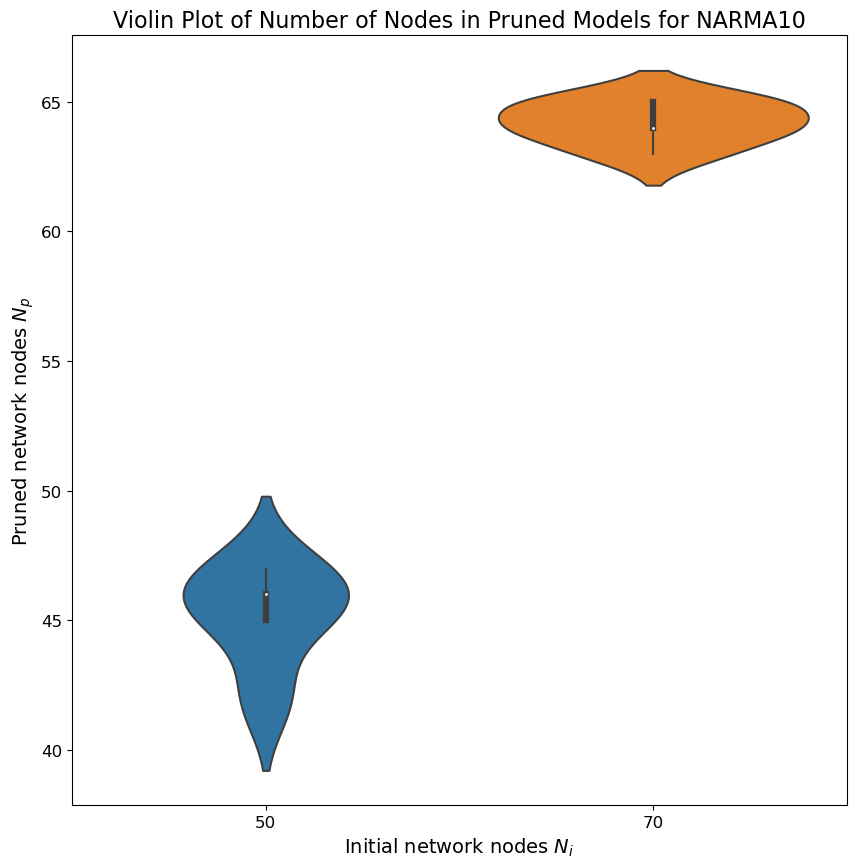

In [37]:
# Extract the number of nodes from the pruned models in dataA and dataB
nodes_dataA = [dataA['Model_pruneds'][i].reservoir_layer.nodes for i in range(len(dataA['Model_pruneds']))]
nodes_dataB = [dataB['Model_pruneds'][i].reservoir_layer.nodes for i in range(len(dataB['Model_pruneds']))]

# Create a dataframe for plotting
data = {
    'Nodes': nodes_dataA + nodes_dataB,
    'Dataset': ['50'] * len(nodes_dataA) + ['70'] * len(nodes_dataB)
}

# Create the violin plot
plt.figure(figsize=(10, 10))
sns.violinplot(x='Dataset', y='Nodes', data=data)

plt.title('Violin Plot of Number of Nodes in Pruned Models for NARMA10', fontsize=16)
plt.ylabel('Pruned network nodes $N_p$', fontsize=14)
plt.xlabel('Initial network nodes $N_i$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [38]:
from scipy.optimize import linear_sum_assignment
import matplotlib.patches as mpatches


def NetPlot(Model_rand, Model_prun):
    A_G = Model_rand.reservoir_layer.weights #np.random.randint(0, 2, (N, N))  # Big graph
    N = Model_rand.reservoir_layer.nodes #50  # Big graph size

    A_Gs = Model_prun.reservoir_layer.weights #np.random.randint(0, 2, (M, M))  # Small graph
    M = Model_prun.reservoir_layer.nodes #20  # Small graph size

    # Convert adjacency matrices to directed graphs
    G = nx.from_numpy_array(A_G, create_using=nx.DiGraph)
    Gs = nx.from_numpy_array(A_Gs, create_using=nx.DiGraph)

    # --- Step 1: Find Best Node Alignment ---
    big_degrees = np.array([G.degree(n) for n in G.nodes])
    small_degrees = np.array([Gs.degree(n) for n in Gs.nodes])

    # Solve assignment problem (Hungarian algorithm) to best align nodes
    cost_matrix = np.abs(big_degrees[:, None] - small_degrees[None, :])  # Cost based on degree differences
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Create a node mapping: match small network nodes to big network nodes
    node_mapping = {list(Gs.nodes)[j]: list(G.nodes)[i] for i, j in zip(row_ind, col_ind)}
    Gs = nx.relabel_nodes(Gs, node_mapping)  # Update Gs labels to fit into G

    # Identify node sets
    big_nodes = set(G.nodes)
    small_nodes = set(Gs.nodes)
    remaining_big_nodes = big_nodes - small_nodes  # Nodes in G that are NOT in Gs

    # --- Step 2: Use the same layout ---
    pos = nx.spring_layout(G, seed=42)  # Consistent layout for both

    # --- Step 3: Plot Correctly ---
    plt.figure(figsize=(10, 10))

    # Draw small graph (ONLY edges between red nodes)
    nx.draw_networkx_nodes(Gs, pos, node_color='red', node_size=50, alpha=0.7)
    nx.draw_networkx_edges(Gs, pos, edge_color='red', alpha=0.5, arrows=True, arrowsize=5, width=0.5)

    # Draw big graph (ONLY edges between gray nodes)
    big_edges = [(u, v) for u, v in G.edges if u in remaining_big_nodes and v in remaining_big_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=remaining_big_nodes, node_color='k', node_size=50, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=big_edges, edge_color='k', alpha=0.5, arrows=True, arrowsize=10)

    gray_patch = mpatches.Patch(color='k', label='Pruned Nodes')
    red_patch = mpatches.Patch(color='red', label='Final Pruned Network')
    plt.legend(handles=[gray_patch, red_patch], loc='upper right')

    plt.title(f"Overlay of Pruned Directed Graph on Original (|G|={N}, |Gs|={M})")
    plt.show()

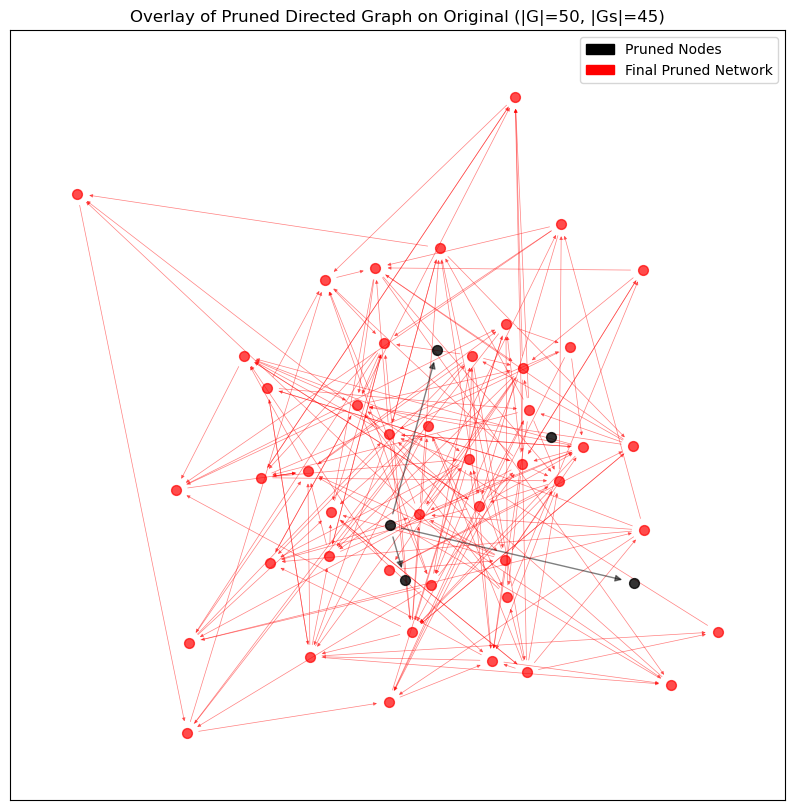

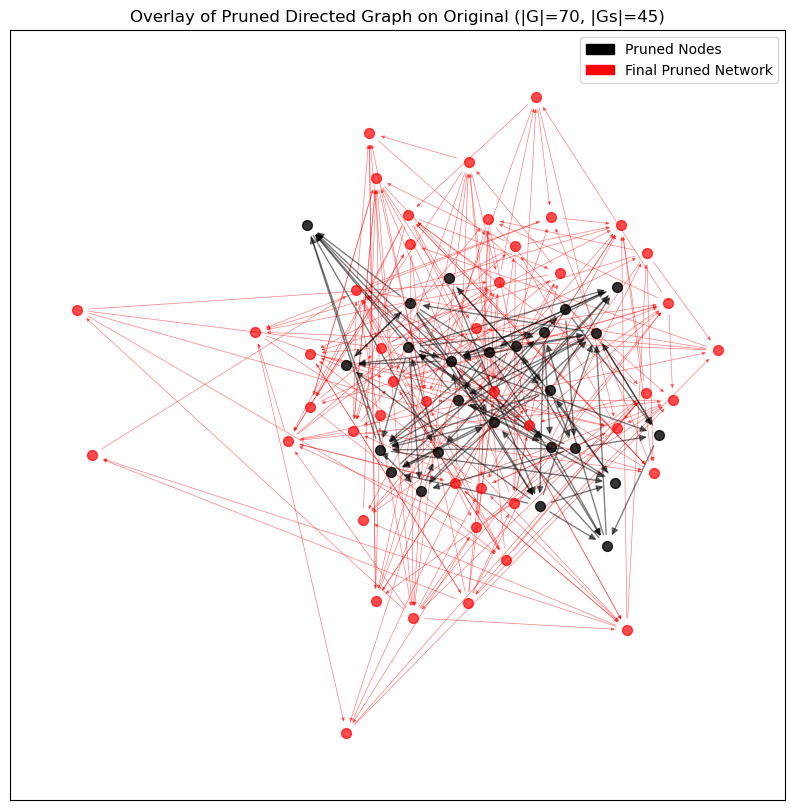

In [39]:
NetPlot(Model_rand=dataA['Model_rands'][0], Model_prun=dataA['Model_pruneds'][0])
NetPlot(Model_rand=dataB['Model_rands'][0], Model_prun=dataA['Model_pruneds'][0])